In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

C:\Users\mateo\AppData\Local\Temp\ipykernel_9736\216217699.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2021-01-01", end="2025-08-04")  # Especificamos el rango de fechas
[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2021-01-04  243.256668  248.163330  239.063339  239.820007  145914600
2021-01-05  245.036667  246.946671  239.733337  241.220001   96735600
2021-01-06  251.993332  258.000000  249.699997  252.830002  134100000
2021-01-07  272.013336  272.329987  258.399994  259.209991  154496700
2021-01-08  293.339996  294.829987  279.463318  285.333344  225166500


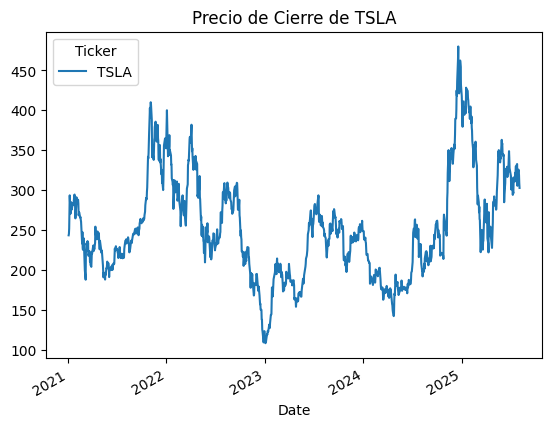

In [2]:
# 1. Especificar el ticker de la acción
ticker = 'TSLA' # Aquí puedes poner el ticker que desees, por ejemplo, AAPL para Apple

# 2. Descargar los precios históricos usando yfinance
data = yf.download(ticker, start="2021-01-01", end="2025-08-04")  # Especificamos el rango de fechas

# 3. Visualizar los primeros registros
print(data.head())

# 4. Opcional: Graficar los precios de cierre
import matplotlib.pyplot as plt

data['Close'].plot(title=f"Precio de Cierre de {ticker}")
plt.show()

In [3]:
#Vemos la estructura de los datos, durante el ultimo año
data[data.index>'2025-01-01'].head()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2025-01-02,379.279999,392.730011,373.040009,390.100006,109710700
2025-01-03,410.440002,411.880005,379.450012,381.480011,95423300
2025-01-06,411.049988,426.429993,401.700012,423.200012,85516500
2025-01-07,394.359985,414.329987,390.000000,405.829987,75699500
2025-01-08,394.940002,402.500000,387.399994,392.950012,73038800


1. Vamos a emplear para el analisis los precios ajustados al cierre. 
Estos precios son mas realistas, pues consideran la reparticion de dividendos, splits, consolidaciones comporativas etc

# Definicion del Movimiento Browniano Geometrico

Se ha demostrado matematicamente que el comportamiento de las acciones se puede modelar con un MBG.

$$dS(t) = \mu S(t) dt + \sigma S(t) dB(t)$$

donde:
- $S(t)$ es el precio en el tiempo $t$,
- $\mu$ es la tasa de crecimiento esperada,
- $\sigma$ es la volatilidad,
- $B(t)$ es un proceso de Wiener, tambien conocido como ruido aleatorio.

La solución de esta ecuación es:

$$S(t+1) = S(t) \exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma B(t)\right)$$



1. Para calcular $\mu$ en primer lugar debemos calcular los retornos logaritmicos para cada momento $t$

$$rt=ln\left(\frac{st}{st-1}\right)$$

In [4]:
data['retornos']=(data['Close'] / data['Close'].shift(1)).apply(lambda x: np.log(x))
data.head()

Price,Close,High,Low,Open,Volume,retornos
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,
Date,,,,,,
2021-01-04,243.256668,248.163330,239.063339,239.820007,145914600,NaN
2021-01-05,245.036667,246.946671,239.733337,241.220001,96735600,0.007291
2021-01-06,251.993332,258.000000,249.699997,252.830002,134100000,0.027995
2021-01-07,272.013336,272.329987,258.399994,259.209991,154496700,0.076448
2021-01-08,293.339996,294.829987,279.463318,285.333344,225166500,0.075481


2. Calculamos la tasa de crecimiento esperada

$$\mu=\frac{1}{N}\sum_{t=1}^{n} rt$$

In [5]:
#Metodo 1
N=len(data)-1 #Menos 1 porque el primer elemento no tiene retorno
mu=data['retornos'].sum()/N
print('el parametro mu del modelo es: ', mu)

el parametro mu del modelo es:  0.00019007295053388444


In [6]:
#Metodo 2
data['retornos'].mean()

0.00019007295053388444

3. Calculamos la volatilidad $\sigma$

$$\sigma = \sqrt{\frac{1}{N-1} \sum_{t=1}^{N} \left( r_t - \mu \right)^2}$$





In [7]:
#Metodo 1
N = len(data['retornos']) -1 # Número total de retornos
sigma = np.sqrt(np.sum((data['retornos'] - mu)**2) / (N - 1))
print('el parametro sigma del modelo es: ', sigma)

el parametro sigma del modelo es:  0.038852419603161895


In [8]:
#Metodo 2
sigma = data['retornos'].std()
sigma

0.038852419603161895

3. Definimos el proceso estocastico asi:

$$st+1=st*EXP\left[\left(\mu -\frac{\sigma^2}{2}\right)dt+\sigma et \sqrt{dt}\right]\$$

donde,

- dt es 1/252 dias de mercado 
- et es un numero aleatorio de una distribucion N(0,1)
- st retorno en el momento t
- st+1 retorno en el momento t+1

In [9]:
#Procedemos a crear una funcion que modele el proceso estocastico
def MGB_acciones(mu,sigma,data,col_name,steps):

    #Los parametros de la funcion son:
    #mu -> Tasa de crecimiento esperada
    #sigma -> volatilidad del activo
    #data -> pandas df que contiene los retornos logaritmicos del activo en dias
    #col_name -> nombre de la columna de los retornos
    #steps -> numero de pasos hacia adelante en el proceso estocastico

    dt=1/252 # son solo 252 dias de traiding en el año.
    s0=data['Close'].iloc[-1].iat[0] #Tomamos el ultimo elemento de los precios, ya que este sera el punto de partida
    et_vector=np.random.normal(loc=0, scale=1, size=steps) # Vector de numeros aletorios de media 0 y desviacion estandar 1
    exp_vector = np.exp((mu - (sigma**2) / 2) * dt + sigma * et_vector * np.sqrt(dt))

    st_1=[]

    for i in range(0,steps):

        if i==0:
            s=s0*exp_vector[0]
        else:
            s=st_1[i-1]*exp_vector[i]

        st_1.append(s)
            

    return st_1

#Probamos la funcion
#MGB_acciones(mu, sigma, data, 'Adj Close',252)

In [10]:
# Funcion que realiza graficos de lineas
def lineas_multiples(data, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y'):
    """
    Función para graficar múltiples líneas con colores aleatorios.
    
    Parámetros:
    - data: DataFrame de pandas con los datos a graficar.
    - title: Título del gráfico.
    - xlabel: Etiqueta del eje X.
    - ylabel: Etiqueta del eje Y.
    """
    plt.figure(figsize=(10, 6))  # Tamaño de la figura
    num_lines = data.shape[1]  # Número de líneas (columnas en el DataFrame)
    
    # Generar un color aleatorio para cada línea
    colors = np.random.rand(num_lines, 3)  # Colores aleatorios en RGB

    for i in range(num_lines):
        plt.plot(np.arange(1, data.shape[0] + 1), data.iloc[:, i], color=colors[i], label=f'Línea {i + 1}')  # Acceso corregido
    
    # Configurar título y etiquetas
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Mostrar la cuadrícula
    plt.grid(True)
    
    # Mostrar leyenda
    #plt.legend()
    
    # Mostrar el gráfico
    plt.show()

In [19]:
sim=500
simulations = []
for i in range(sim):
    s = pd.Series(MGB_acciones(mu, sigma, data, 'Close', 252))
    s.name = f'sim_{i}'
    simulations.append(s)

Montecarlo_results = pd.concat(simulations, axis=1)

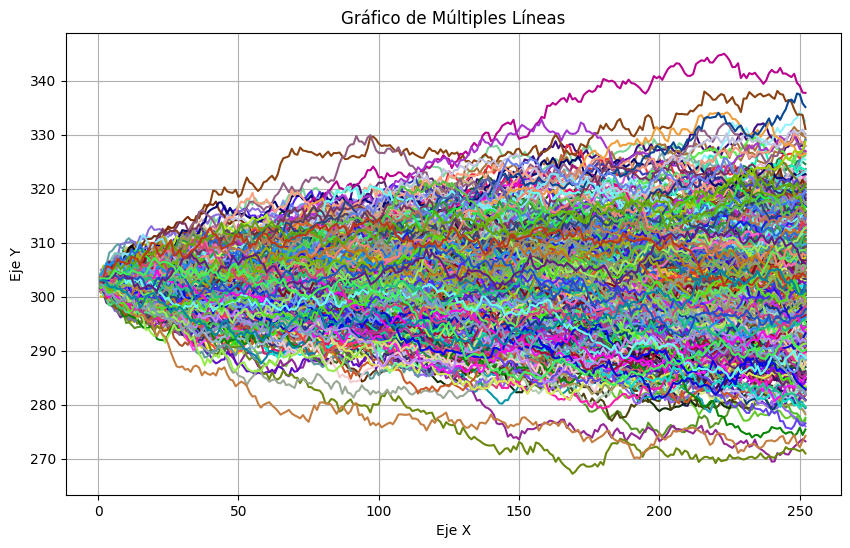

In [20]:
#Graficamos
lineas_multiples(Montecarlo_results, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y')

In [21]:
#Calculamos la probabilidad de perder 5% de la inversion inicial en el próximo año
alfa=0.05
s0=data['Close'].iloc[-1].iat[0]
print('El precio de compra es: ', s0)

El precio de compra es:  302.6300048828125


In [22]:
Montecarlo_results.tail()

,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,...,sim_490,sim_491,sim_492,sim_493,sim_494,sim_495,sim_496,sim_497,sim_498,sim_499
247,300.835164,299.528841,302.198717,309.021893,300.202020,307.645917,307.422583,296.634098,309.434531,303.806196,...,295.413905,296.313515,303.253744,284.203802,296.029486,320.137086,309.239881,303.965098,291.009611,302.206807
248,299.888546,298.683371,302.705434,309.339822,300.698613,307.391384,307.993876,295.633605,310.267663,303.403937,...,294.795550,296.787264,302.086169,283.303685,296.491327,321.009666,308.811819,303.353527,290.860679,300.801710
249,299.695866,298.887261,302.315144,310.198451,301.923225,307.001924,307.095056,295.352131,309.674766,303.517595,...,294.928556,296.575885,300.264656,282.864188,296.348478,319.624053,307.208360,303.518217,290.213887,300.376870
250,300.163810,297.968124,302.321871,309.703133,302.158004,306.826209,307.353434,294.955807,308.858224,304.941796,...,295.574299,297.495520,300.287074,282.828903,296.831327,319.982348,306.362067,304.347532,289.867456,300.496231
251,300.728373,298.670671,301.696257,310.803071,302.981194,306.585126,307.243865,294.049141,309.949657,305.540313,...,295.744805,298.252974,300.540065,281.925310,297.614097,320.526616,306.170226,303.743090,290.172098,302.063665


In [23]:
precios_cierre = Montecarlo_results.iloc[-1,:] #Seleccionamos los precios finales a un año de inversion
precios_cierre

sim_0      300.728373
sim_1      298.670671
sim_2      301.696257
sim_3      310.803071
sim_4      302.981194
              ...    
sim_495    320.526616
sim_496    306.170226
sim_497    303.743090
sim_498    290.172098
sim_499    302.063665
Name: 251, Length: 500, dtype: float64

In [24]:
total=len(precios_cierre)
exito=len(precios_cierre[precios_cierre<(s0*(1-alfa))])

p=exito/total

print(p*100,'%')

10.8 %


In [25]:
total=len(precios_cierre)
exito=len(precios_cierre[precios_cierre>(s0*(1.1))])
p=exito/total

print(p*100,'%')

0.4 %
